# Machine Learning - Gözetimli Öğrenme: Airbnb Open Data ile Model Karşılaştırması

Bu çalışmada, Airbnb Open Data veri seti üzerinde gözetimli öğrenme algoritmalarından **Lojistik Regresyon**, **Karar Ağaçları** ve **k-En Yakın Komşu (KNN)** modellerini karşılaştıracağız. Çapraz doğrulama ile modellerin performansını inceleyecek, en iyi modeli seçip hiperparametre optimizasyonu uygulayacağız.

Kullanılan veri seti: **Airbnb_Open_Data.csv**

Özellikler: fiyat, hizmet ücreti, minimum gece, oda tipi, mahalle, konum (enlem, boylam), inceleme sayısı, vb.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [16]:
df = pd.read_csv('datasets/Airbnb_Open_Data.csv')
df.head()

<ipython-input-16-e0139c550da8>:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/Airbnb_Open_Data.csv')


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


Veri setinin genel yapısını ve eksik değerleri inceleyelim.

In [17]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83619 entries, 0 to 83618
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              83619 non-null  int64  
 1   NAME                            83399 non-null  object 
 2   host id                         83619 non-null  int64  
 3   host_identity_verified          83375 non-null  object 
 4   host name                       83265 non-null  object 
 5   neighbourhood group             83590 non-null  object 
 6   neighbourhood                   83603 non-null  object 
 7   lat                             83611 non-null  float64
 8   long                            83611 non-null  float64
 9   country                         83259 non-null  object 
 10  country code                    83523 non-null  object 
 11  instant_bookable                83523 non-null  object 
 12  cancellation_policy             

,0
id,0
NAME,220
host id,0
host_identity_verified,244
host name,354
neighbourhood group,29
neighbourhood,16
lat,8
long,8
country,360


Analiz için kullanılacak önemli sayısal sütunları seçip eksik değerleri temizleyelim.

In [18]:
columns_to_use = ['price', 'service fee', 'minimum nights', 'number of reviews', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365']
df_selected = df[columns_to_use + ['room type']].dropna()

Fiyat ve hizmet ücreti sütunlarını sayısal formata dönüştürelim.

In [19]:
for col in ['price', 'service fee']:
    df_selected[col] = (
        df_selected[col]
        .astype(str)
        .str.replace(r'[^0-9.]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )
df_selected = df_selected.dropna()

Oda tipini kategorik değişkenden sayısal değere dönüştürelim.

In [20]:
df_selected['room type'] = df_selected['room type'].astype('category').cat.codes

Seçilen sütunların istatistiksel özetini inceleyelim.

In [21]:
df_selected.describe()

,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,room type
count,69424.000000,69424.000000,69424.000000,69424.000000,69424.000000,69424.000000,69424.000000,69424.000000,69424.000000
mean,625.603538,125.121773,7.758571,33.222747,1.380851,3.294279,7.702005,146.407597,0.943319
std,331.924885,66.389331,30.019863,54.206832,1.772465,1.275215,31.899564,134.271780,1.026253
min,50.000000,10.000000,-365.000000,1.000000,0.010000,1.000000,1.000000,-10.000000,0.000000
25%,339.000000,68.000000,2.000000,3.000000,0.230000,2.000000,1.000000,10.000000,0.000000
50%,625.000000,125.000000,3.000000,11.000000,0.760000,3.000000,1.000000,113.000000,0.000000
75%,913.000000,183.000000,5.000000,39.000000,2.000000,4.000000,3.000000,272.000000,2.000000
max,1200.000000,240.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000,3.000000


## Özellik Seçimi & Korelasyon Matrisi
Veri setindeki sayısal değişkenler arasındaki korelasyonu inceleyelim ve önemli özellikleri belirleyelim.

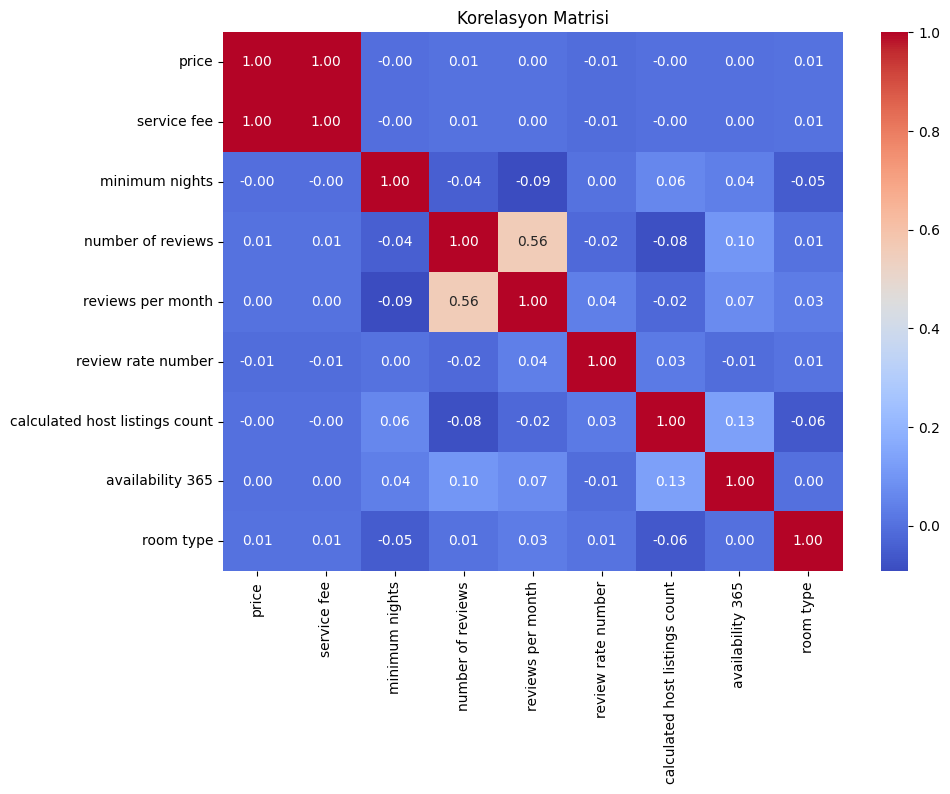

In [22]:
plt.figure(figsize=(10,7))
sns.heatmap(df_selected.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

Hedef değişken olarak "price" sütununu kullanacağız. Fiyatı medyan değere göre sınıflandırarak ikili sınıflandırma problemi oluşturacağız.

In [23]:
median_price = df_selected['price'].median()
df_selected['price_class'] = (df_selected['price'] > median_price).astype(int)

Özellik ve hedef değişkenlerimizi ayıralım.

In [24]:
X = df_selected.drop(['price', 'price_class'], axis=1).values
y = df_selected['price_class'].values

Veri setini eğitim ve test olarak bölelim.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Veri setindeki farklı ölçeklerin etkisini azaltmak için standartlaştırma işlemi uygulayalım.

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelin Görselleştirilmesi

In [27]:
# En iyi modeli bulmak için cross_val_score sonuçlarını saklıyoruz

def get_cv_score(model):
    from sklearn.model_selection import cross_val_score
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

model_objs = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]
model_names = ['Logistic Regression', 'Decision Tree', 'KNN']
cv_scores = [get_cv_score(m) for m in model_objs]

best_idx = int(np.argmax(cv_scores))
best_model_name = model_names[best_idx]
print(f"En yüksek doğruluk: {best_model_name} ({cv_scores[best_idx]:.3f})")

En yüksek doğruluk: Decision Tree (0.998)


## En İyi Model ile Veri Üzerinde Sınıflandırma Sonuçlarının Görselleştirilmesi
Aşağıda, en iyi modelin test verisi üzerindeki tahmin sonuçları iki boyutlu bir dağılım grafiği ile gösterilmiştir. (İlk iki özellik kullanılmıştır.)

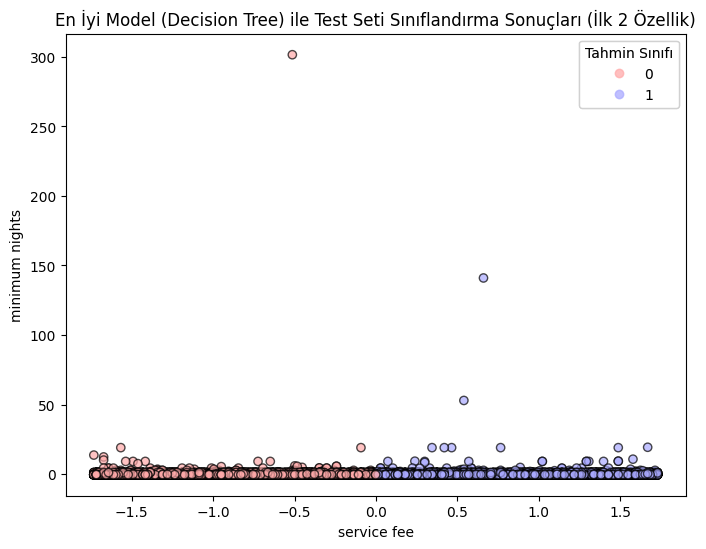

In [28]:
from matplotlib.colors import ListedColormap

# Test verisinde ilk iki özellik kullanılarak görselleştirme yapıldı.
X_vis = X_test[:, :2]
y_true = y_test

# En iyi model yeniden eğitildi. (tüm X_train ile)
best_model_vis = model_objs[best_idx].fit(X_train, y_train)
y_pred = best_model_vis.predict(X_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_pred, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.7, edgecolor='k', label='Tahmin')
plt.xlabel(df_selected.drop(['price', 'price_class'], axis=1).columns[0])
plt.ylabel(df_selected.drop(['price', 'price_class'], axis=1).columns[1])
plt.title(f"En İyi Model ({best_model_name}) ile Test Seti Sınıflandırma Sonuçları (İlk 2 Özellik)")
legend1 = plt.legend(*scatter.legend_elements(), title="Tahmin Sınıfı")
plt.gca().add_artist(legend1)
plt.show()

Çapraz doğrulama ile Lojistik Regresyon, Karar Ağacı ve KNN modellerinin başarımını karşılaştıralım.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")

Logistic Regression CV Accuracy: 0.998 (+/- 0.000)
Decision Tree CV Accuracy: 0.998 (+/- 0.000)
KNN CV Accuracy: 0.976 (+/- 0.002)


Modellerin tamamı fiyat sınıflandırma görevinde yüksek doğruluk değerleri elde etmiştir. Lojistik Regresyon ve Karar Ağacı modelleri, 0.998 ortalama doğruluk ve düşük standart sapma ile benzer performanslar göstermiştir. Bu sonuçlar, modellerin veri seti üzerindeki sınıflandırma görevini başarılı bir şekilde gerçekleştirdiğini göstermektedir. Bu nedenle, Lojistik Regresyon veya Karar Ağacı modelleri uygun seçenekler olarak değerlendirilebilir.

Bu değerlendirmeler sonucunda Lojistik Regresyon modeli tercih edilmiş ve sonraki adımlarda bu model ile devam edilmiştir.

In [30]:
# Örneğin, Logistic Regression en iyi ise:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Seçilen modelin hiperparametrelerini Grid Search ile optimize edelim.

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
gs = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)
print("Best Params:", gs.best_params_)
print("Best CV Score:", gs.best_score_)

Best Params: {'C': 10, 'solver': 'liblinear'}
Best CV Score: 0.9984335273550673


Optimum parametrelerle modelin test verisi üzerindeki başarımını inceleyelim.

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
best_model = gs.best_estimator_
pred = best_model.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6946
           1       1.00      1.00      1.00      6939

    accuracy                           1.00     13885
   macro avg       1.00      1.00      1.00     13885
weighted avg       1.00      1.00      1.00     13885

[[6935   11]
 [  23 6916]]


## Sonuç

Bu çalışmada, Airbnb Open Data veri seti üzerinde fiyat sınıflandırması için Lojistik Regresyon, Karar Ağacı ve K-Nearest Neighbors (KNN) algoritmalarını kullandık. Modellerin performanslarını çapraz doğrulama yöntemiyle değerlendirdik ve GridSearchCV ile hiperparametre optimizasyonu yaptık. En iyi sonuç veren modelin parametrelerini belirleyerek nihai modelin başarımını detaylı şekilde inceledik.